# Avocado Prices — EDA, Feature Engineering, Model Training

Этот ноутбук делает:
1. Загрузку и первичный анализ данных.
2. Визуализацию временных рядов, ADF, декомпозицию, ACF/PACF, распределение.
3. Создание лагов и rolling-фич по группам `region × type`.
4. Train/Test split по времени (80/20).
5. Обучение RandomForest + CatBoost и ансамблирование.
6. Оценку качества и графики fact vs pred.
7. Сохранение артефактов модели.

> Датасет: `avocado.csv` с Kaggle.


In [36]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import joblib

from catboost import CatBoostRegressor

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


## 1. Загрузка данных

Скачай `avocado.csv` с Kaggle и положи рядом с ноутбуком.

In [37]:
df = pd.read_csv("avocado.csv")
print(df.shape)
df.head()

(18249, 14)


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [38]:
df.info()
df.describe(include="all").T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18249 entries, 0 to 18248
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    18249 non-null  int64  
 1   Date          18249 non-null  object 
 2   AveragePrice  18249 non-null  float64
 3   Total Volume  18249 non-null  float64
 4   4046          18249 non-null  float64
 5   4225          18249 non-null  float64
 6   4770          18249 non-null  float64
 7   Total Bags    18249 non-null  float64
 8   Small Bags    18249 non-null  float64
 9   Large Bags    18249 non-null  float64
 10  XLarge Bags   18249 non-null  float64
 11  type          18249 non-null  object 
 12  year          18249 non-null  int64  
 13  region        18249 non-null  object 
dtypes: float64(9), int64(2), object(3)
memory usage: 1.9+ MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Unnamed: 0,18249.0,NaN,NaN,NaN,24.232232,15.481045,0.0,10.0,24.0,38.0,52.0
Date,18249,169,2015-12-27,108,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AveragePrice,18249.0,NaN,NaN,NaN,1.405978,0.402677,0.44,1.1,1.37,1.66,3.25
Total Volume,18249.0,NaN,NaN,NaN,850644.013009,3453545.355399,84.56,10838.58,107376.76,432962.29,62505646.52
4046,18249.0,NaN,NaN,NaN,293008.424531,1264989.081763,0.0,854.07,8645.3,111020.2,22743616.17
4225,18249.0,NaN,NaN,NaN,295154.568356,1204120.401135,0.0,3008.78,29061.02,150206.86,20470572.61
4770,18249.0,NaN,NaN,NaN,22839.735993,107464.068435,0.0,0.0,184.99,6243.42,2546439.11
Total Bags,18249.0,NaN,NaN,NaN,239639.20206,986242.399216,0.0,5088.64,39743.83,110783.37,19373134.37
Small Bags,18249.0,NaN,NaN,NaN,182194.686696,746178.514962,0.0,2849.42,26362.82,83337.67,13384586.8
Large Bags,18249.0,NaN,NaN,NaN,54338.088145,243965.964547,0.0,127.47,2647.71,22029.25,5719096.61


In [39]:
print("Пропущенные значения:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

print("\nДубликаты:", df.duplicated().sum())

Пропущенные значения:
Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

Дубликаты: 0


## 2. Подготовка даты и базовая очистка

In [40]:
df = df.drop(columns=["Unnamed: 0"], errors="ignore")

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

df["year_from_date"] = df["Date"].dt.year
df["month"] = df["Date"].dt.month
df["weekofyear"] = df["Date"].dt.isocalendar().week.astype(int)
df["quarter"] = df["Date"].dt.quarter

df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,year_from_date,month,weekofyear,quarter
0,2015-01-04,1.75,27365.89,9307.34,3844.81,615.28,13598.46,13061.10,537.36,0.0,organic,2015,Southeast,2015,1,1,1
1,2015-01-04,1.49,17723.17,1189.35,15628.27,0.00,905.55,905.55,0.00,0.0,organic,2015,Chicago,2015,1,1,1
2,2015-01-04,1.68,2896.72,161.68,206.96,0.00,2528.08,2528.08,0.00,0.0,organic,2015,HarrisburgScranton,2015,1,1,1
3,2015-01-04,1.52,54956.80,3013.04,35456.88,1561.70,14925.18,11264.80,3660.38,0.0,conventional,2015,Pittsburgh,2015,1,1,1
4,2015-01-04,1.64,1505.12,1.27,1129.50,0.00,374.35,186.67,187.68,0.0,organic,2015,Boise,2015,1,1,1


Удален лишний столбец индексов

Столбец Date приведен к формату datetime

Данные отсортированы по времени (критично для временных рядов)

Сгенерированы календарные признаки: год, месяц, неделя года, квартал

## 3. Визуализация временного ряда

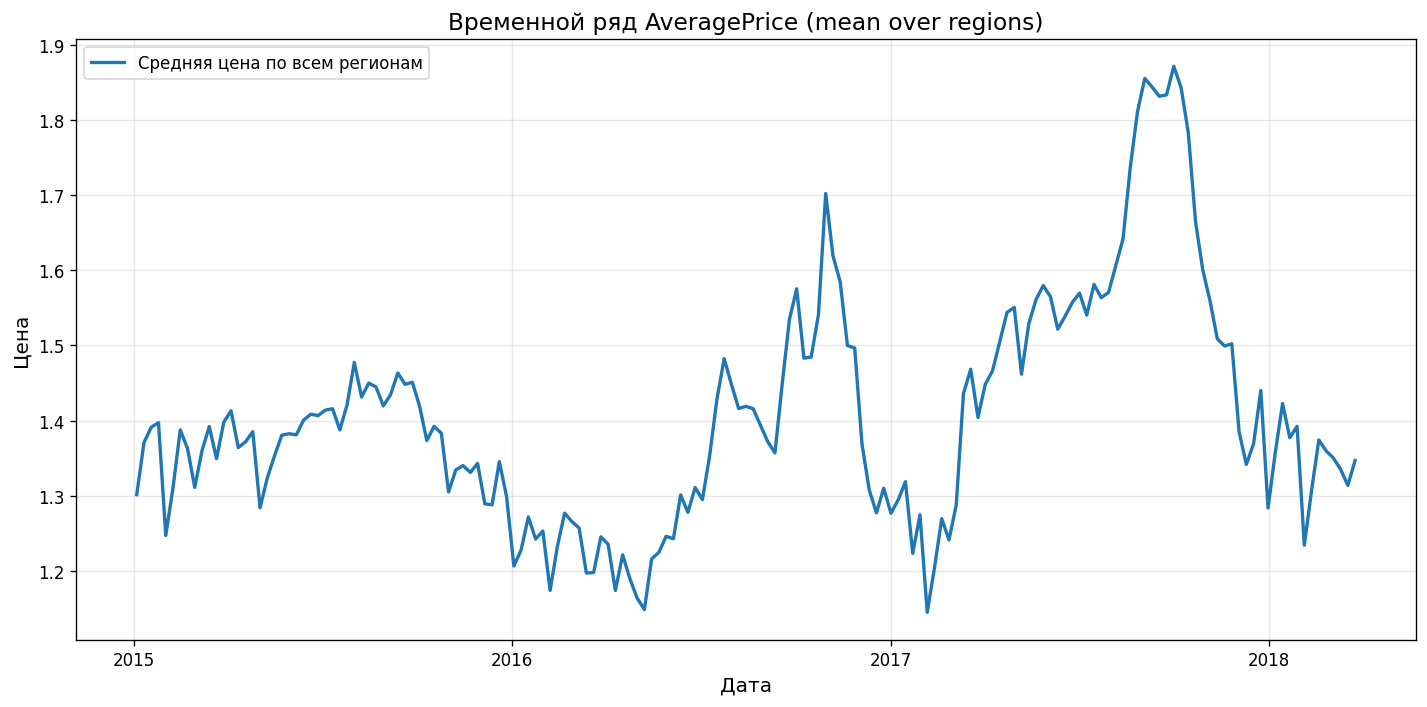

In [41]:
ts_all = df.groupby("Date")["AveragePrice"].mean().sort_index()

plt.figure(figsize=(12,6), dpi=120)
plt.plot(ts_all.index, ts_all.values, linewidth=2, label="Средняя цена по всем регионам")
plt.title("Временной ряд AveragePrice (mean over regions)", fontsize=14)
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена", fontsize=12)
plt.grid(alpha=0.3)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.legend()
plt.tight_layout()
plt.show()

Тренд: Видны колебания цены с течением времени (рост в 2017)

Сезонность: Наблюдаются повторяющиеся паттерны (пики и спады) каждый год

## 4. Декомпозиция ряда (trend/seasonal/resid)

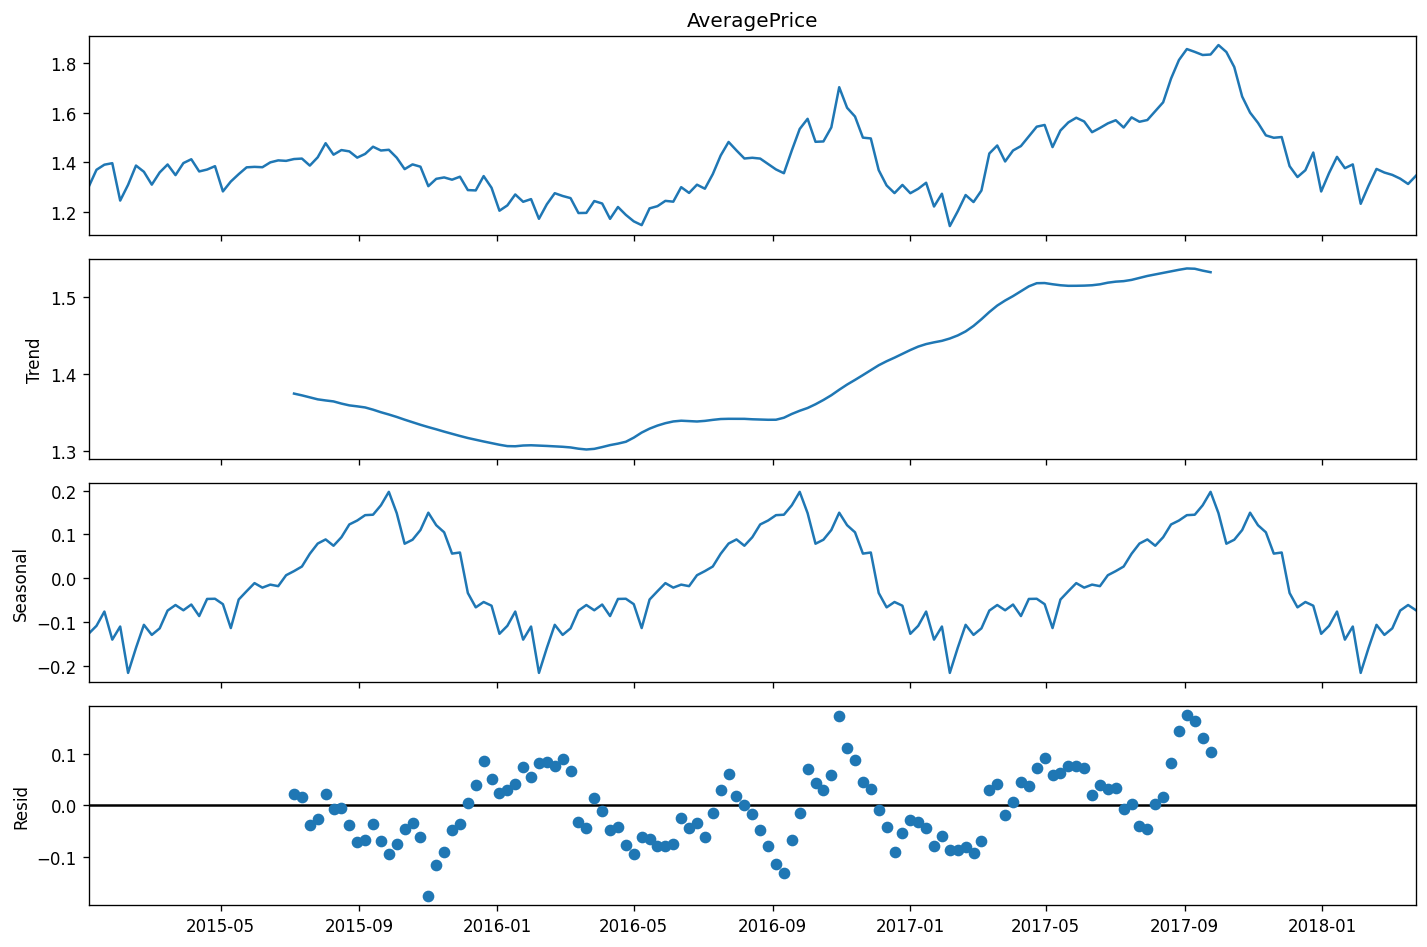

In [42]:
# недельные данные -> сезонность 52 недели
result = seasonal_decompose(ts_all, model='additive', period=52)

fig = result.plot()
fig.set_size_inches(12, 8)
fig.set_dpi(120)
plt.tight_layout()
plt.show()

Trend: Общее направление движения цены (виден рост к середине 2017 года)

Seasonal: Четкая годовая цикличность (периодичность 52 недели)

Resid: Шумовая составляющая (случайные колебания, не объясненные трендом и сезонностью)

## 5. ACF / PACF

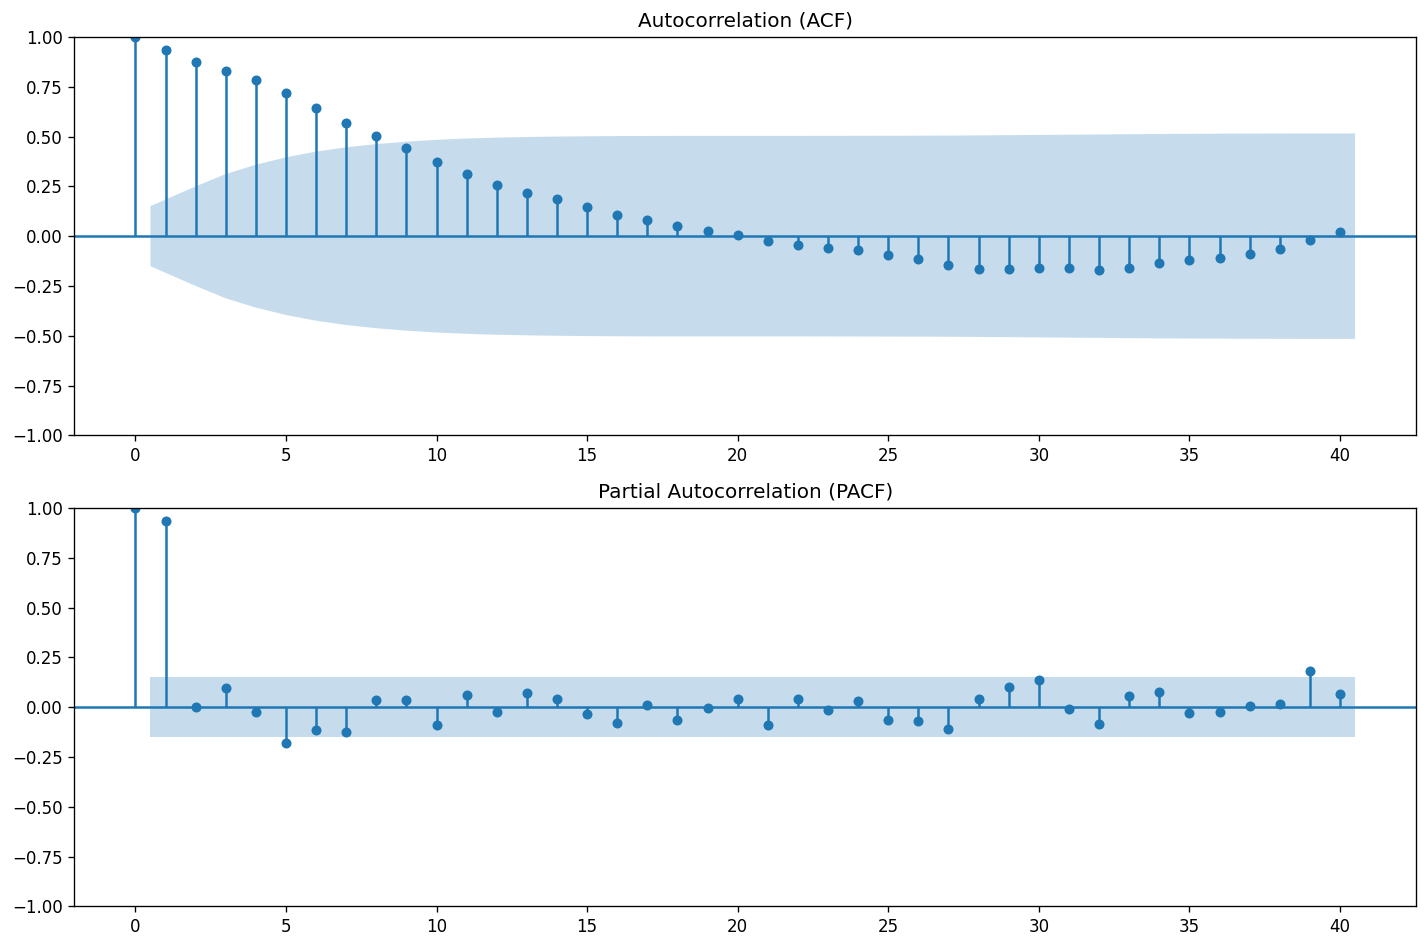

In [43]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12,8), dpi=120)

plot_acf(ts_all.dropna(), lags=40, ax=ax1)
ax1.set_title("Autocorrelation (ACF)")

plot_pacf(ts_all.dropna(), lags=40, ax=ax2, method="ywm")
ax2.set_title("Partial Autocorrelation (PACF)")

plt.tight_layout()
plt.show()

ACF (Автокорреляция): Медленное убывание говорит о наличии тренда. Высокая корреляция с недавним прошлым

PACF (Частичная автокорреляция): Резкий обрыв после первых лагов указывает на то, что именно ближайшие прошлые значения (1-2 недели назад) наиболее важны для прогноза

## 6. Анализ распределения (гистограмма + KDE)

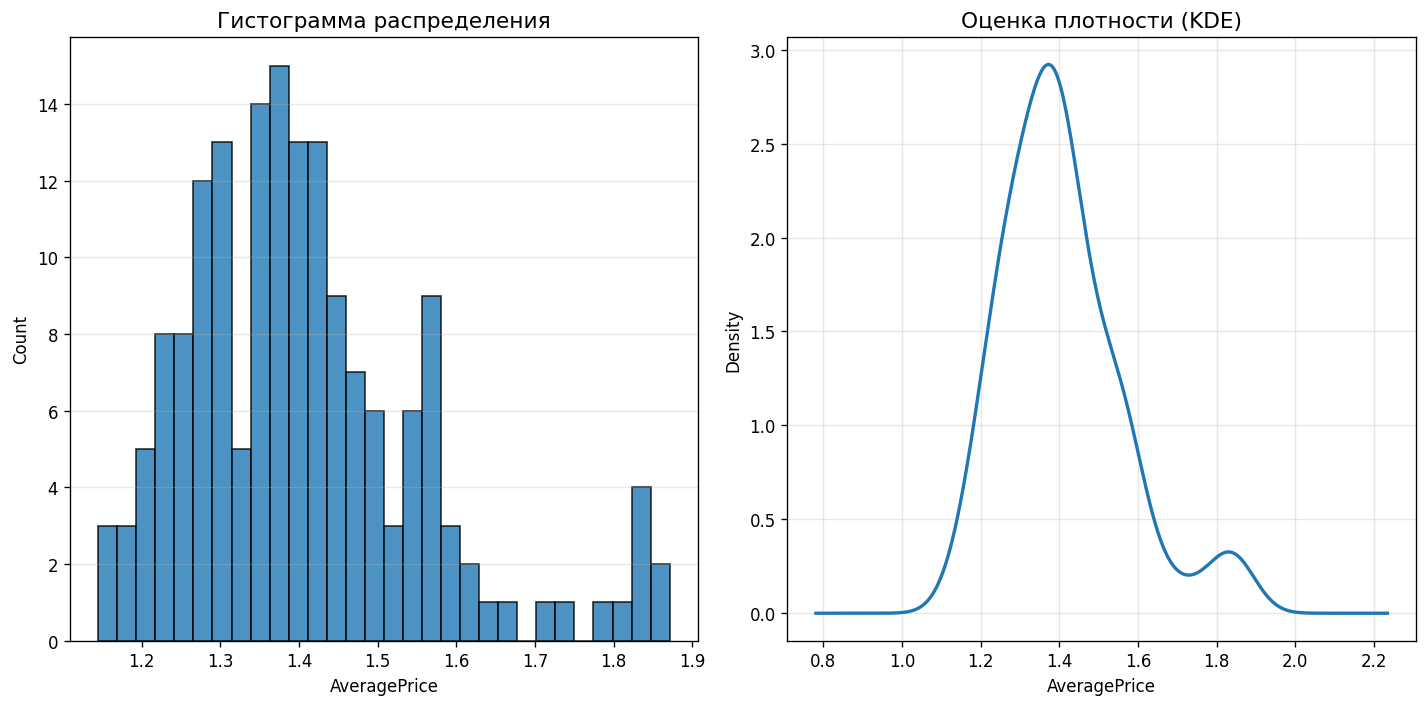

In [44]:
plt.figure(figsize=(12,6), dpi=120)

plt.subplot(1,2,1)
plt.hist(ts_all.values, bins=30, edgecolor="black", alpha=0.8)
plt.title("Гистограмма распределения", fontsize=13)
plt.xlabel("AveragePrice")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)

plt.subplot(1,2,2)
ts_all.plot(kind='kde', linewidth=2)
plt.title("Оценка плотности (KDE)", fontsize=13)
plt.xlabel("AveragePrice")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Распределение целевой переменной AveragePrice похоже на нормальное, но имеет небольшую правостороннюю асимметрию (хвост справа)

Это обосновывает использование логарифмирования объекта в дальнейшем для улучшения качества моделей

## 7. Feature engineering (лаги и rolling)

In [45]:
group_cols = ["region", "type"]

# price lags
for lag in [1, 2, 3, 4]:
    df[f"price_lag_{lag}"] = df.groupby(group_cols)["AveragePrice"].shift(lag)

# volume lags
for lag in [1, 2, 4]:
    df[f"vol_lag_{lag}"] = df.groupby(group_cols)["Total Volume"].shift(lag)

# rolling mean/std of past prices
df["price_roll_mean_4"] = (
    df.groupby(group_cols)["AveragePrice"]
      .shift(1)
      .rolling(window=4)
      .mean()
)
df["price_roll_std_4"] = (
    df.groupby(group_cols)["AveragePrice"]
      .shift(1)
      .rolling(window=4)
      .std()
)

df = df.dropna().reset_index(drop=True)
print("After FE:", df.shape)

After FE: (17817, 26)


Лаги (Lags): Значения цены 1, 2, 3, 4 недели назад

Rolling Features: Скользящее среднее и стандартное отклонение за окном в 4 недели (сглаживает шум)

Удалены строки с NaN, возникшие из-за сдвига данных

## 8. Лог-трансформация таргета

In [46]:
df["log_price"] = np.log(df["AveragePrice"])

Применение np.log к цене

Это сжимает разброс значений и делает распределение более симметричным, что помогает линейным моделям и нейросетям (для деревьев эффект меньше, но полезен)

## 9. Формирование X/y

In [47]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

target = "log_price"

future_cols = [
    'Total Volume', 
    '4046', '4225', '4770', 
    'Total Bags', 'Small Bags', 'Large Bags', 'XLarge Bags'
]
drop_cols = ["AveragePrice", "log_price", "Date"] + future_cols

X = df.drop(columns=drop_cols, errors='ignore') 
y = df[target]

y (Target): Логарифмированная цена

X (Features): Удалены лишние столбцы (даты, исходная цена) и признаки, которые могут привести к утечке данных ("data leakage"), если они неизвестны на момент прогноза

## 10. Train/Test split по времени

In [48]:
# Разделение данных на train/valid/test (70%/15%/15%)
train_idx = int(len(df) * 0.7)
valid_idx = train_idx + int(len(df) * 0.15)

X_train = X.iloc[:train_idx]
X_valid = X.iloc[train_idx:valid_idx]
X_test  = X.iloc[valid_idx:]

y_train = y.iloc[:train_idx]
y_valid = y.iloc[train_idx:valid_idx]
y_test  = y.iloc[valid_idx:]

print("Train shape:", X_train.shape)
print("Valid shape:", X_valid.shape)
print("Test shape:", X_test.shape)

Train shape: (12471, 16)
Valid shape: (2672, 16)
Test shape: (2674, 16)


Разделение на выборки по времени, а не случайно (Shuffle=False). Это очень важно при работе с временными рядами

Разделение:

    Train (70%): Обучение на части данных

    Valid (15%): Подбор гиперпараметров, валдиация

    Test (15%): Итоговая проверка на "будущем"

## 11. Препроцессинг

In [49]:
cat_cols = ['region', 'type']

# Определяем числовые признаки (все колонки X, кроме категориальных)
# Теперь X точно определен как DataFrame, и ошибка уйдет
num_cols = [c for c in X.columns if c not in cat_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols),
    ]
)

print("Размерность X:", X.shape)
print("Категориальные фичи:", cat_cols)
print(f"Числовые фичи ({len(num_cols)}):", num_cols)

Размерность X: (17817, 16)
Категориальные фичи: ['region', 'type']
Числовые фичи (14): ['year', 'year_from_date', 'month', 'weekofyear', 'quarter', 'price_lag_1', 'price_lag_2', 'price_lag_3', 'price_lag_4', 'vol_lag_1', 'vol_lag_2', 'vol_lag_4', 'price_roll_mean_4', 'price_roll_std_4']


Категории (region, type): Кодируются через OneHotEncoding

Числа: Оставляем как есть (деревянные модели не требуют масштабирования)

## 12. Подготовка данных и признаков

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def create_lag_rolling_features(df, group_cols=['region', 'type'], target_col='AveragePrice', lags=[1, 2, 3, 4], window=4):
    df = df.copy()
    df = df.sort_values(group_cols + ['Date']).reset_index(drop=True)
    
    for lag in lags:
        df[f'lag{lag}'] = df.groupby(group_cols)[target_col].shift(lag)
    
    # Скользящие окна (сдвиг на 1, чтобы не заглядывать в будущее)
    df['rolling_mean_4'] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).mean()
    )
    df['rolling_std_4'] = df.groupby(group_cols)[target_col].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=1).std()
    )
    return df.dropna()

def train_valid_test_split(df, train_size=0.7, valid_size=0.1, test_size=0.2):
    train_end = int(len(df) * train_size)
    valid_end = int(len(df) * (train_size + valid_size))
    return df.iloc[:train_end].copy(), df.iloc[train_end:valid_end].copy(), df.iloc[valid_end:].copy()

df_with_features = create_lag_rolling_features(df)
train_df, valid_df, test_df = train_valid_test_split(df_with_features)

lag_features = ['lag1', 'lag2', 'lag3', 'lag4']
rolling_features = ['rolling_mean_4', 'rolling_std_4']
categorical_features = ['region', 'type']
numerical_features = ['year', 'month', 'weekofyear', 'quarter'] + lag_features + rolling_features

features = numerical_features + categorical_features
target = 'AveragePrice'

X_train, y_train = train_df[features], train_df[target]
X_valid, y_valid = valid_df[features], valid_df[target]
X_test, y_test = test_df[features], test_df[target]

print(f"Размеры выборок: Train {X_train.shape}, Valid {X_valid.shape}, Test {X_test.shape}")

Размеры выборок: Train (12169, 12), Valid (1738, 12), Test (3478, 12)


## 13. Обучение моделей и оценка

In [34]:
def evaluate_model(model, X, y, model_name):
    y_pred = model.predict(X)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mean_squared_error(y, y_pred))
    r2 = r2_score(y, y_pred)
    print(f"{model_name} -> MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f}")
    return y_pred, mae, rmse, r2

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

# 2Обучение RandomForest
print("\n--- Training RandomForest ---")
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1))
])
rf_model.fit(X_train, y_train)

# Обучение CatBoost
print("\n--- Training CatBoost ---")
cat_features_indices = [i for i, col in enumerate(features) if col in categorical_features]
catboost_model = CatBoostRegressor(
    iterations=1000, learning_rate=0.1, depth=6, 
    random_state=42, verbose=0, early_stopping_rounds=50
)
catboost_model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=cat_features_indices)

# Валидация и Тест
print("\n=== TEST SET RESULTS ===")
# Получаем предсказания
test_pred_rf, test_mae_rf, test_rmse_rf, test_r2_rf = evaluate_model(rf_model, X_test, y_test, "RandomForest")
test_pred_catboost, test_mae_cb, test_rmse_cb, test_r2_cb = evaluate_model(catboost_model, X_test, y_test, "CatBoost")

# Ансамбль (усрднение)
test_pred_ensemble = (test_pred_rf + test_pred_catboost) / 2
ensemble_mae = mean_absolute_error(y_test, test_pred_ensemble)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, test_pred_ensemble))
ensemble_r2 = r2_score(y_test, test_pred_ensemble)

print(f"Ensemble -> MAE: {ensemble_mae:.4f} | RMSE: {ensemble_rmse:.4f} | R²: {ensemble_r2:.4f}")


--- Training RandomForest ---

--- Training CatBoost ---

=== TEST SET RESULTS ===
RandomForest -> MAE: 0.1024 | RMSE: 0.1555 | R²: 0.8493
CatBoost -> MAE: 0.1010 | RMSE: 0.1525 | R²: 0.8552
Ensemble -> MAE: 0.1007 | RMSE: 0.1527 | R²: 0.8548


Обучены RandomForest и CatBoost

CatBoost показал результат лучше (меньше MAE/RMSE, выше R²), так как лучше работает с категориями и временными рядами

Ensemble: Дал наилучший результат, снизив дисперсию ошибки. R² ~ 0.85 говорит о том, что модель объясняет 85% вариации цены

## 14. Визуализация, Важность признаков и Сохранение

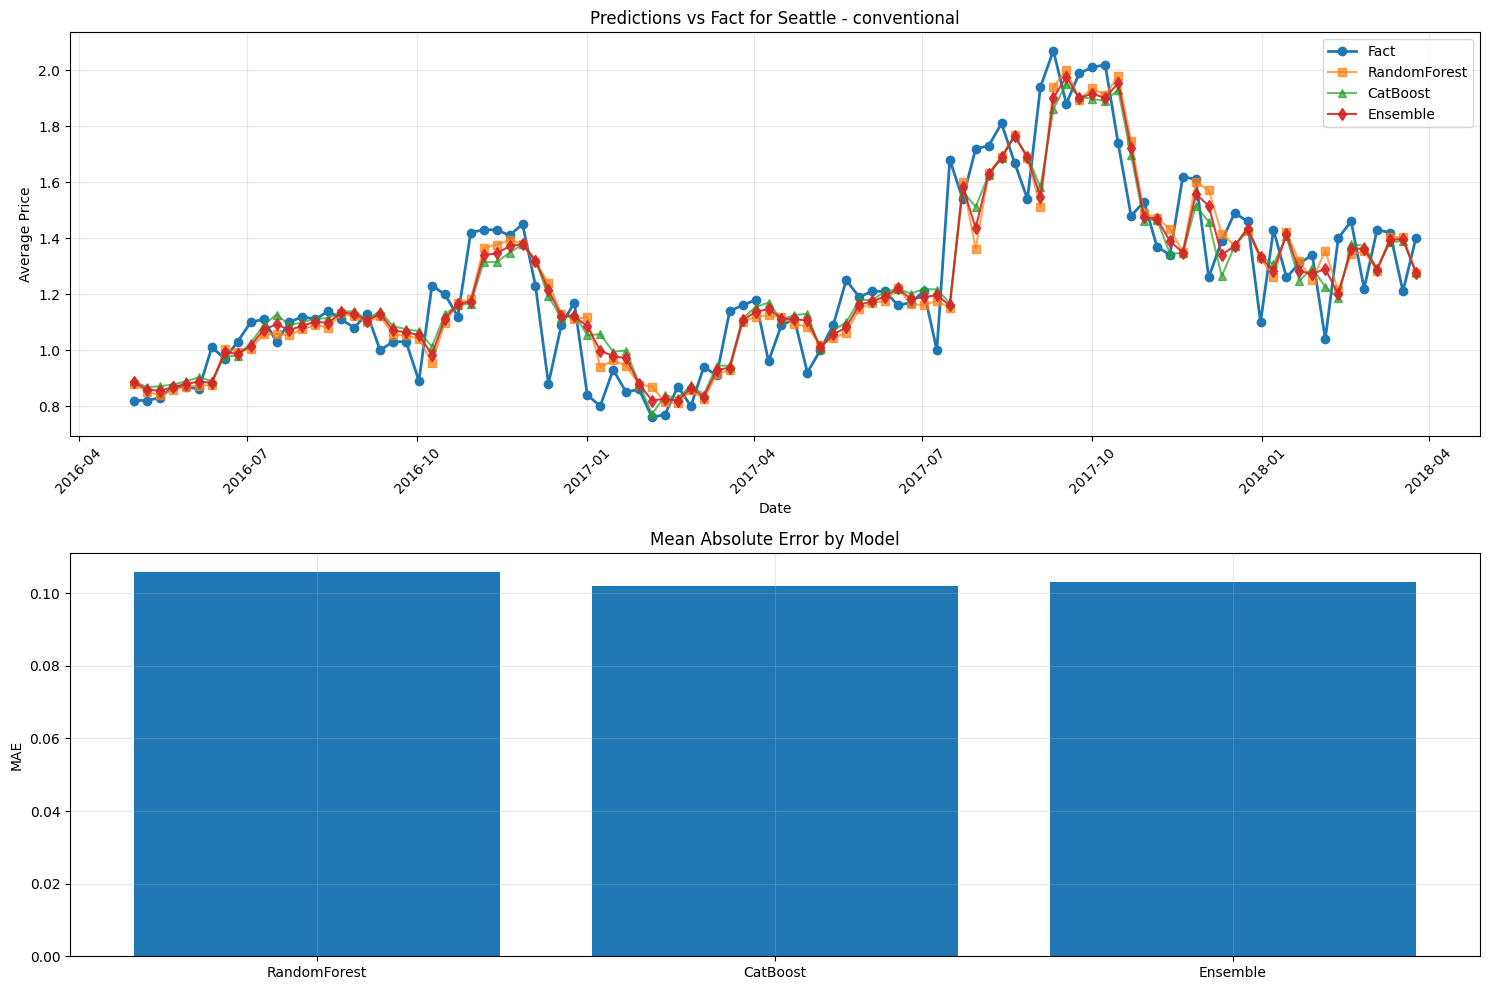


Saving unified artifact...
Saved: avocado_artifact.pkl


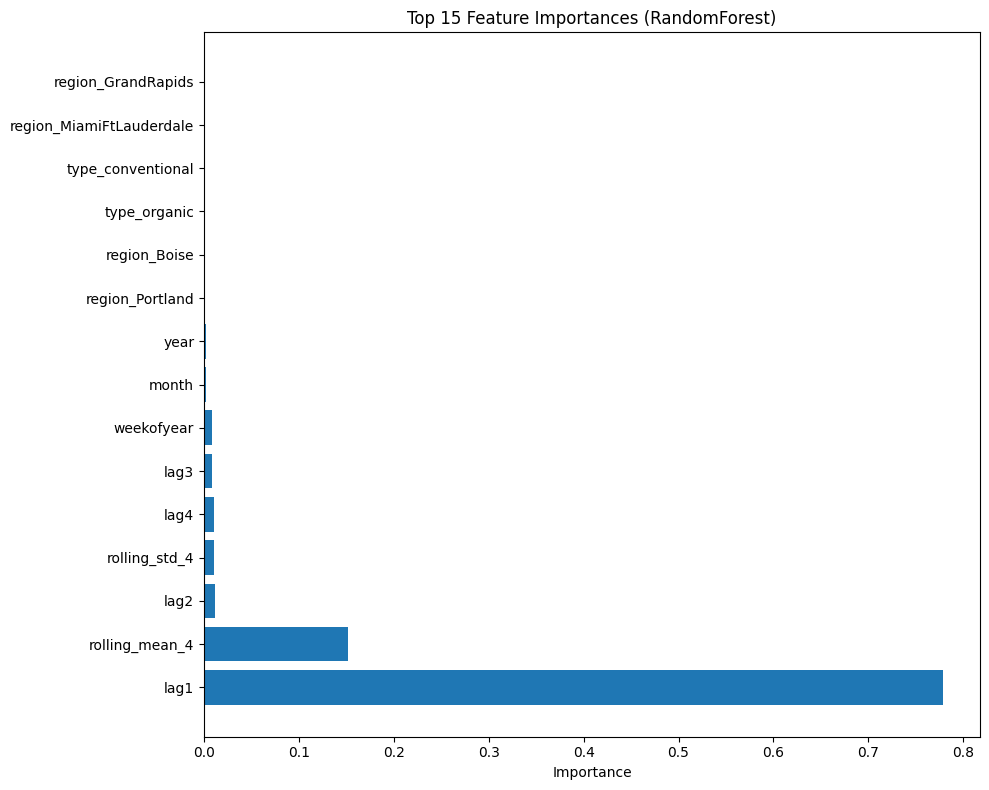

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib

# Визуализация: Факт vs Прогноз и Ошибки
plt.figure(figsize=(15, 10))

# Подготовка выборки (один регион, один тип)
sample_region = test_df['region'].iloc[0]
sample_type = test_df['type'].iloc[0]
mask = (test_df['region'] == sample_region) & (test_df['type'] == sample_type)

sample_test = test_df[mask]
sample_pred_rf = test_pred_rf[mask.values]
sample_pred_catboost = test_pred_catboost[mask.values]
sample_pred_ensemble = test_pred_ensemble[mask.values]

# Подграфик 1: Временной ряд
plt.subplot(2, 1, 1)
plt.plot(sample_test['Date'], sample_test['AveragePrice'], label='Fact', linewidth=2, marker='o')
plt.plot(sample_test['Date'], sample_pred_rf, label='RandomForest', alpha=0.7, marker='s')
plt.plot(sample_test['Date'], sample_pred_catboost, label='CatBoost', alpha=0.7, marker='^')
plt.plot(sample_test['Date'], sample_pred_ensemble, label='Ensemble', alpha=0.9, marker='d')

plt.title(f"Predictions vs Fact for {sample_region} - {sample_type}")
plt.xlabel('Date')
plt.ylabel('Average Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Подграфик 2: Столбчатая диаграмма ошибок
plt.subplot(2, 1, 2)
errors = {
    'RandomForest': np.abs(sample_test['AveragePrice'] - sample_pred_rf),
    'CatBoost': np.abs(sample_test['AveragePrice'] - sample_pred_catboost),
    'Ensemble': np.abs(sample_test['AveragePrice'] - sample_pred_ensemble)
}

plt.bar(errors.keys(), [np.mean(errors[key]) for key in errors.keys()])
plt.title('Mean Absolute Error by Model')
plt.ylabel('MAE')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Сохранение модели
print("\nSaving unified artifact...")

artifact = {
    "rf_model": rf_model,                        
    "catboost_model": catboost_model,             
    "features": features,                         
    "numerical_features": numerical_features,
    "categorical_features": categorical_features,
    "cat_features_indices": cat_features_indices,
    "metrics_test": {
        "rf": {"mae": test_mae_rf, "rmse": test_rmse_rf, "r2": test_r2_rf},
        "catboost": {"mae": test_mae_cb, "rmse": test_rmse_cb, "r2": test_r2_cb},
        "ensemble": {"mae": ensemble_mae, "rmse": ensemble_rmse, "r2": ensemble_r2},
    }
}

joblib.dump(artifact, "avocado_artifact.pkl")
print("Saved: avocado_artifact.pkl")

# Важность признаков
feature_names = (
    numerical_features +
    list(
        rf_model.named_steps['preprocessor']
        .named_transformers_['cat']
        .get_feature_names_out(categorical_features)
    )
)

importances = rf_model.named_steps['regressor'].feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(
    feature_importance_df['feature'].head(15),
    feature_importance_df['importance'].head(15)
)
plt.title('Top 15 Feature Importances (RandomForest)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

Временной ряд (Prediction vs Fact): Модели (особенно ансамбль) очень точно повторяют динамику реальной цены на тестовом периоде

Ошибки (Bar chart): Ансамбль дает минимальную среднюю абсолютную ошибку (MAE)


Важность признаков (Feature Importance):

    1. Самые важные признаки — Lag 1 и Rolling Mean (цена неделю назад и средняя цена за месяц)

    2. Это подтверждает, что текущая цена сильнее всего зависит от ближайшей истории цен